### Data preparation

In [ ]:
import json
import pandas as pd

In [ ]:
with open('probe_labels.json') as f:
  result = json.load(f)
  print(result)
data_train=[]
data_test=[]

{'annotations': [{'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 0}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 1}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 2}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 3}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 4}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 5}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 6}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 7}, {'bbox': [77.0, 0.0, 138.0, 247.0], 'image_id': 8}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 10}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 11}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 12}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 13}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 14}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 15}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 16}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 17}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 18}, {'bbox': [90.0, 0.0, 133.0, 208.0], 'i

In [ ]:
bboxes = []
image_ids = {annotation.get('image_id') for annotation in result.get('annotations')}
bboxes.append(annotation.get('bbox') for annotation in result.get('annotations'))

In [ ]:
for i in bboxes:
  for j in i:
    print(j)

In [ ]:
for annotation in result['annotations']:
  image_id = annotation['image_id']
  bbox = annotation['bbox']

  for img in result["images"]:
    if img["id"] == image_id:
      file_name = img["file_name"]
      data_train.append({
         "id" : image_id,
         "file_name" : file_name,
         "bbox_coords" : bbox
      })




In [ ]:
# pd.DataFrame([[k] + v for k,v in data_train.items()], columns=["id",
#                                          "file_name","bbox_coords"])

In [ ]:
# type(df.bbox_coords)

In [ ]:
df = pd.DataFrame(data_train)
df[['start_x','start_y','end_x','end_y']] = pd.DataFrame(df.bbox_coords.tolist(), index= df.index)
df = df.drop(['bbox_coords','id'], axis=1)

In [ ]:
df.to_csv('out.csv', index=False)

### Data preprocessing

In [1]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

### Display Images

In [2]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [3]:
import os
import sys
os.getcwd()
IMAGES_PATH ="/content/probe_images"
print(os.listdir(IMAGES_PATH))
print(len(os.listdir(IMAGES_PATH)))

['E300PREMP00002_00725_216_1flight_4500_2.jpg', 'E300PREMP00002_00725_216_1flight_10500_2.jpg', 'E300PREMP00002_00726_217_1flight_600_2.jpg', 'E300PREMP00002_00725_216_1flight_9300_2.jpg', 'E300PREMP00002_00726_217_1flight_4200_2.jpg', 'E300PREMP00002_00726_217_1flight_3600_2.jpg', 'E300PREMP00002_00726_217_1flight_1200_2.jpg', 'E300PREMP00002_00725_216_1flight_5100_2.jpg', 'E300PREMP00002_00725_216_1flight_7500_2.jpg', 'E300PREMP00002_00725_216_1flight_6900_2.jpg', 'E300PREMP00002_00725_216_1flight_300_2.jpg', 'E300PREMP00002_00725_216_1flight_8700_2.jpg', 'E300PREMP00002_00726_217_1flight_4800_2.jpg', 'E300PREMP00002_00725_216_1flight_1500_2.jpg', 'E300PREMP00002_00726_217_1flight_3000_2.jpg', 'E300PREMP00002_00726_217_1flight_0_2.jpg', 'E300PREMP00002_00726_217_1flight_2400_2.jpg', 'E300PREMP00002_00725_216_1flight_12300_2.jpg', 'E300PREMP00002_00725_216_1flight_11100_2.jpg', 'E300PREMP00002_00725_216_1flight_6300_2.jpg', 'E300PREMP00002_00725_216_1flight_9900_2.jpg', 'E300PREMP0000

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
class Config:
    # define the base path to the input dataset and then use it to derive
    # the path to the images directory and annotation CSV file
    IMAGES_PATH ="/content/probe_images"
    TEST_IMAGES_PATH ="/content/probe_test_images"
    ANNOTS_PATH ="/content/out.csv"

    # define the path to the base output directory
    BASE_OUTPUT = "output"

    # define the path to the output serialized model, model training plot,
    # and testing image filenames
    MODEL_PATH = "/content/detector.h5"
    PLOT_PATH = "/content/plot.png"
    # testFilenames = "/content/test_images.txt"

    # initialize our initial learning rate, number of epochs to train
    # for, and the batch size
    INIT_LR = 1e-4
    NUM_EPOCHS = 30
    BATCH_SIZE = 16

# instantiate the config class
config = Config()

### Bounding box regression training

In [5]:
# # load the contents of the CSV annotations file
# print("[INFO] loading dataset...")
# rows = open(config.ANNOTS_PATH).read().strip().split("\n")
# firstLine = rows.pop(0)
# # initialize the list of data (images), our target output predictions
# # (bounding box coordinates), along with the filenames of the
# # individual images
# data = []
# targets = []
# filenames = []

In [6]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(config.ANNOTS_PATH).read().strip().split("\n")
firstLine = rows.pop(0)
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [7]:
files = [f for f in os.listdir(config.IMAGES_PATH) if f not in (os.listdir(config.TEST_IMAGES_PATH))]
# print(len(files))
docs = np.array(files)

#split the train set to train and val with ratio 9:1
ratio = 0.9
doc_split = np.split(docs, [round(len(docs) * ratio)])
print(len(doc_split[0]), len(doc_split[1])) # split into 249 and 28

idx = np.hstack((np.ones(len(doc_split[0])), np.zeros(len(doc_split[1])))) # generate indices
np.random.shuffle(idx) # shuffle to make training data and val data random

train = docs[idx == 1]
val = docs[idx == 0]

249 28


In [8]:
# imagePath = os.path.sep.join([config.IMAGES_PATH, "E300PREMP00002_00725_216_1flight_10500_2.jpg"])
# print(imagePath)
# image = cv2.imread(imagePath)
# (h, w) = image.shape[:2]
# print("height = " + str(h) + "\n" + "width = " + str(w))

In [9]:
# # loop over the rows
# for row in rows:
#   # break the row into the filename and bounding box coordinates
# 	row = row.split(",")
# 	(filename, startX, startY, endX, endY) = row

# 	# derive the path to the input image, load the image (in OpenCV
# 	# format), and grab its dimensions
# 	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
# 	print(imagePath)
# 	image = cv2.imread(imagePath)
# 	(h, w) = image.shape[:2]
# 	# print("height = " + str(h) + "\n" + "width = " + str(w))

# 	# scale the bounding box coordinates relative to the spatial
# 	# dimensions of the input image
# 	startX = float(startX) / w
# 	startY = float(startY) / h
# 	endX = float(endX) / w
# 	endY = float(endY) / h

# 	# load the image and preprocess it
# 	image = load_img(imagePath, target_size=(224, 224))
# 	image = img_to_array(image)

# 	# update our list of data, targets, and filenames
# 	data.append(image)
# 	targets.append((startX, startY, endX, endY))
# 	filenames.append(filename)

In [10]:
global trainImages, trainTargets, trainFilenames, valImages, valTargets, valFilenames, testImages, testTargets, testFilenames
trainImages = []
trainTargets = []
trainFilenames = []
valImages = []
valTargets = []
valFilenames = []
testImages = []
testTargets = []
testFilenames = []

In [12]:
# testImg = []
rows = open(config.ANNOTS_PATH).read().strip().split("\n")
firstLine = rows.pop(0)
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row

	# derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
	print(imagePath)
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]
	# print("height = " + str(h) + "\n" + "width = " + str(w))

	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h

	# load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)

	if filename in train:
		# update our list of data, targets, and filenames
		print("I am in train")
		trainImages.append(image)
		trainTargets.append((startX, startY, endX, endY))
		trainFilenames.append(filename)

	elif filename in val:
		# update our list of data, targets, and filenames
		print("I am in val")
		valImages.append(image)
		valTargets.append((startX, startY, endX, endY))
		valFilenames.append(filename)

	elif filename in (os.listdir(config.TEST_IMAGES_PATH)):
		# update our list of data, targets, and filenames
		print("I am in test")
		testImages.append(image)
		testTargets.append((startX, startY, endX, endY))
		testFilenames.append(filename)


# train_images, trainTargets, trainFilenames, valImages, valTargets, valFilenames, testImages, testTargets, testFilenames = SplitToTrainTestVal()

/content/probe_images/E300PREMP00002_00725_216_1flight_300_2.jpg
I am in test
/content/probe_images/E300PREMP00002_00725_216_1flight_900_2.jpg
I am in test
/content/probe_images/E300PREMP00002_00725_216_1flight_1500_2.jpg
I am in train
/content/probe_images/E300PREMP00002_00725_216_1flight_2100_2.jpg
I am in train
/content/probe_images/E300PREMP00002_00725_216_1flight_2700_2.jpg
I am in val
/content/probe_images/E300PREMP00002_00725_216_1flight_3300_2.jpg
I am in val
/content/probe_images/E300PREMP00002_00725_216_1flight_3900_2.jpg
I am in test
/content/probe_images/E300PREMP00002_00725_216_1flight_4500_2.jpg
I am in train
/content/probe_images/E300PREMP00002_00725_216_1flight_5100_2.jpg
I am in train
/content/probe_images/E300PREMP00002_00725_216_1flight_6300_2.jpg
I am in test
/content/probe_images/E300PREMP00002_00725_216_1flight_6900_2.jpg
I am in train
/content/probe_images/E300PREMP00002_00725_216_1flight_7500_2.jpg
I am in val
/content/probe_images/E300PREMP00002_00725_216_1flig

In [13]:
trainImages = np.array(trainImages, dtype="float32") / 255.0
trainTargets = np.array(trainTargets, dtype="float32")
valImages = np.array(valImages, dtype="float32") / 255.0
valTargets = np.array(valTargets, dtype="float32")
testImages = np.array(testImages, dtype="float32") / 255.0
testTargets = np.array(testTargets, dtype="float32")

In [42]:
# for row in rows:
#   # break the row into the filename and bounding box coordinates
# 	# row = row.split(",")
# 	# (filename, startX, startY, endX, endY) = row
# 	# print(row[0])
#   print(row)

In [43]:
# # convert the data and targets to NumPy arrays, scaling the input
# # pixel intensities from the range [0, 255] to [0, 1]
# data = np.array(data, dtype="float32") / 255.0
# targets = np.array(targets, dtype="float32")

# # partition the data into training and testing splits using 90% of
# # the data for training and the remaining 10% for testing
# split = train_test_split(data, targets, filenames, test_size=0.10,
# 	random_state=42)

# # unpack the data split
# (trainImages, testImages) = split[:2]
# (trainTargets, testTargets) = split[2:4]
# (trainFilenames, testFilenames) = split[4:]

# # write the testing filenames to disk so that we can use then
# # when evaluating/testing our bounding box regressor
# print("[INFO] saving testing filenames...")
# f = open(config.testFilenames, "w")
# f.write("\n".join(testFilenames))
# f.close()

In [44]:
# split


In [14]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
# bboxHead = Dense(256, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(flatten)
# bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# lr=config.INIT_LR
# type(lr)

In [ ]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=config.INIT_LR)
model.compile(loss="mse", optimizer=opt, metrics=['accuracy'])
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(valImages, valTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,936,548 (68.42 MB)

 Trainable params: 3,221,860 (12.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
[INFO] training bounding box regressor...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 186s 11s/step - accuracy: 0.9145 - loss: 0.0029 - val_accuracy: 0.8571 - val_loss: 0.0052
Epoch 2/30
13/16 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - accuracy: 0.9210 - loss: 9.6567e-04

[INFO] saving object detector model...


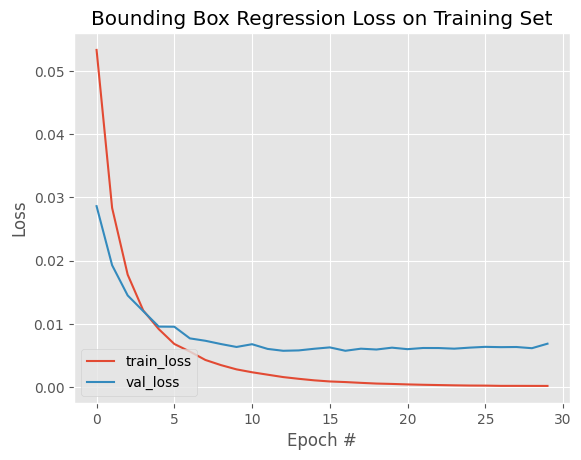

In [16]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")

# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

[INFO] saving object detector model...


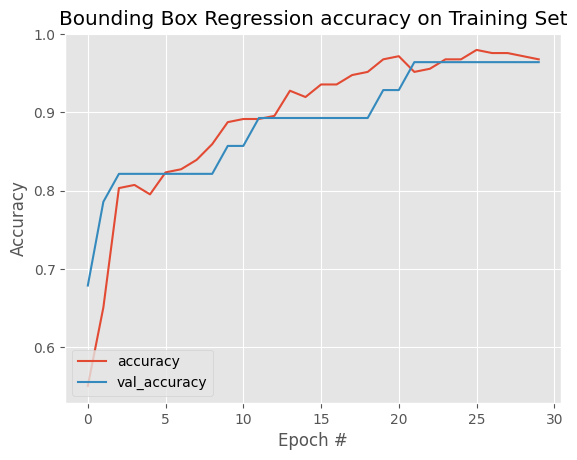

In [17]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")

# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")

plt.title("Bounding Box Regression accuracy on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

### bounding box predictor

In [18]:
imagePaths = []
for f in (os.listdir(config.TEST_IMAGES_PATH)):
  # construct the full path to the image filename and then
  # update our image paths list
  p = os.path.sep.join([config.IMAGES_PATH, f])
  imagePaths.append(p)

[INFO] loading object detector...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


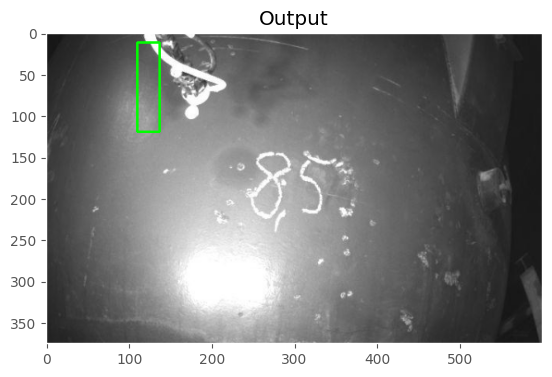

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


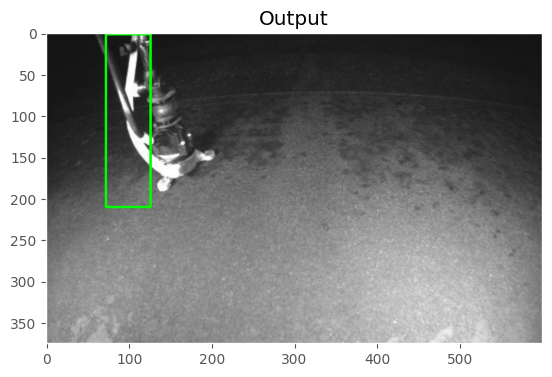

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


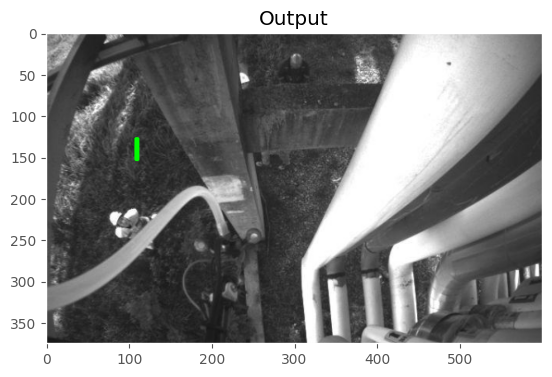

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


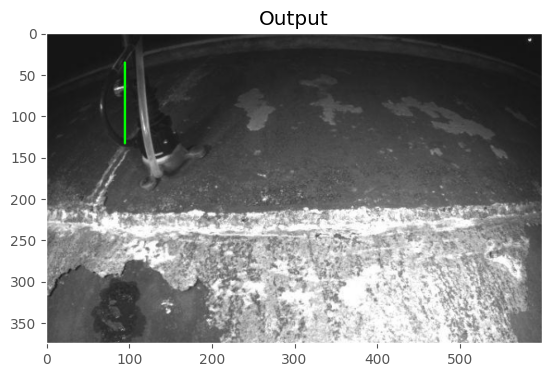

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


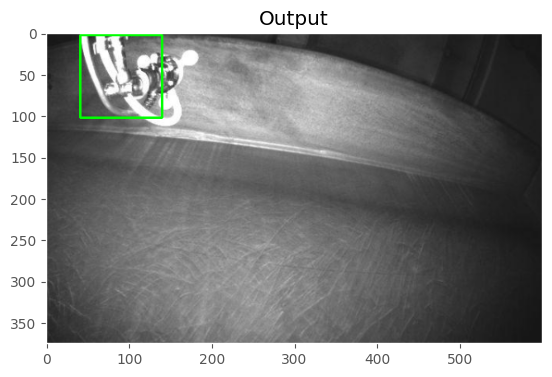

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


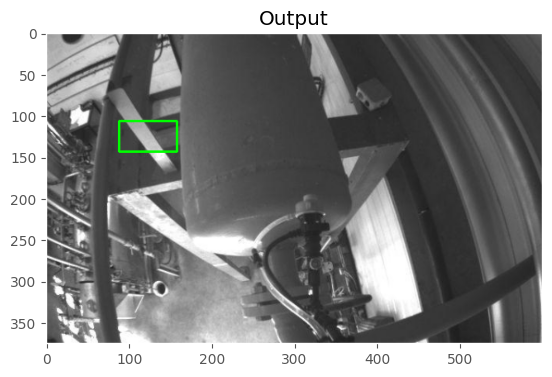

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


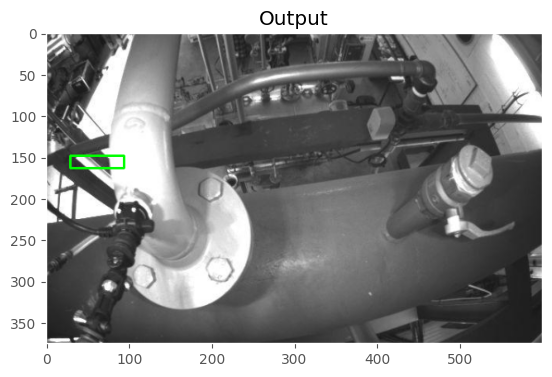

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


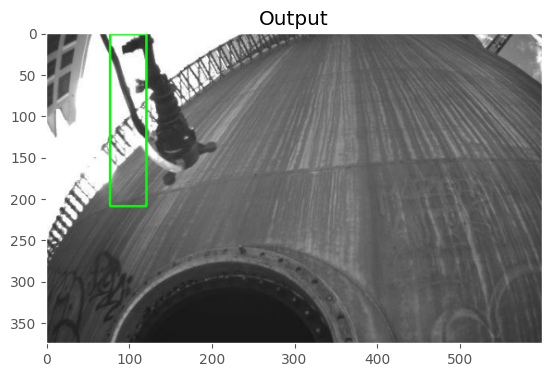

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


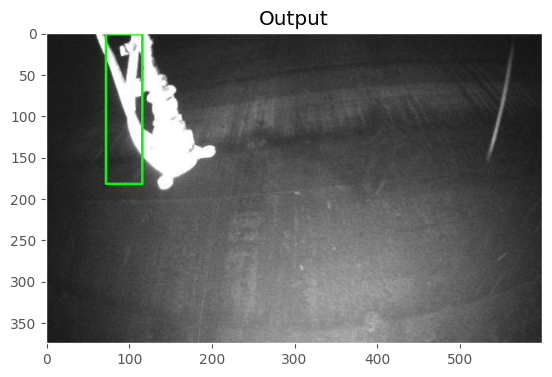

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


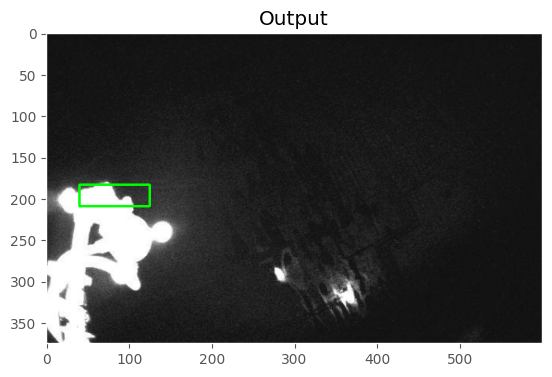

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


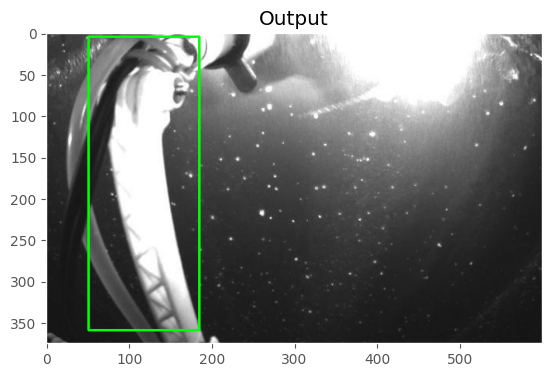

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


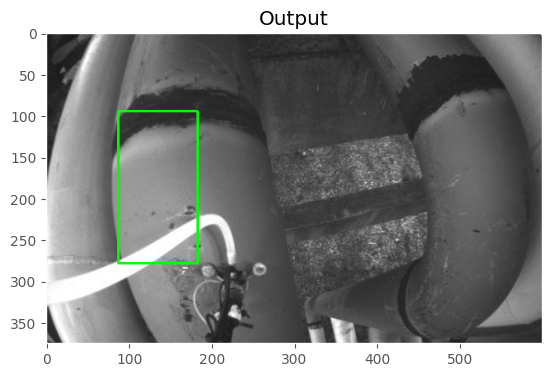

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


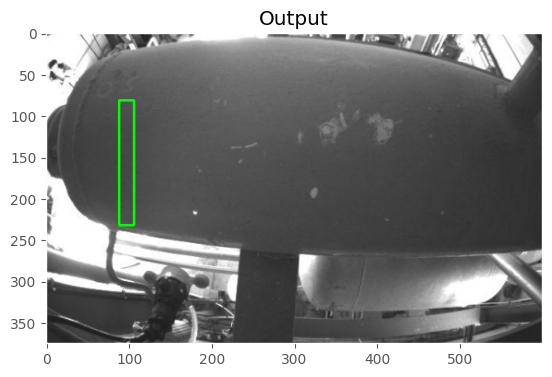

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


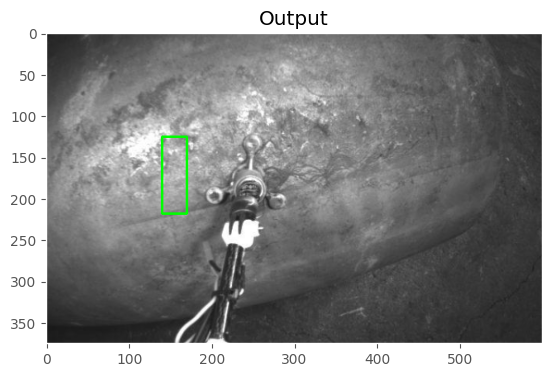

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


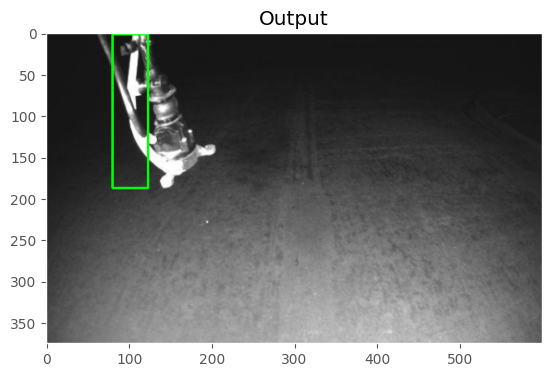

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


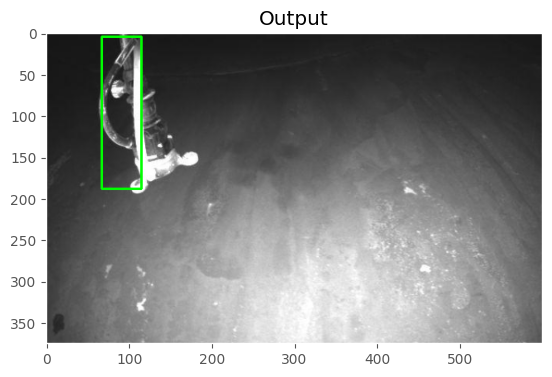

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


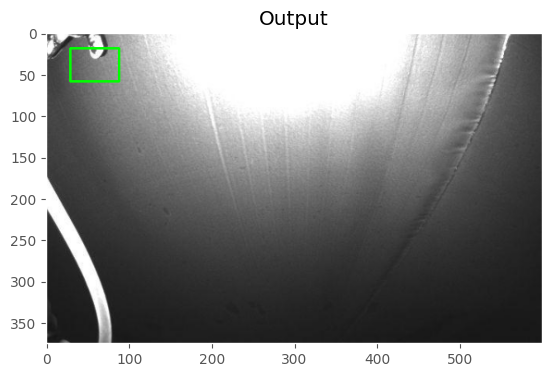

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


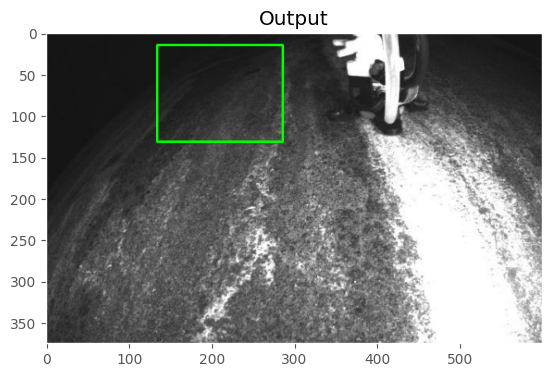

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


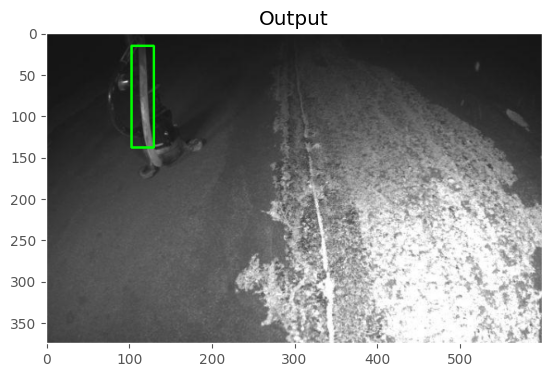

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


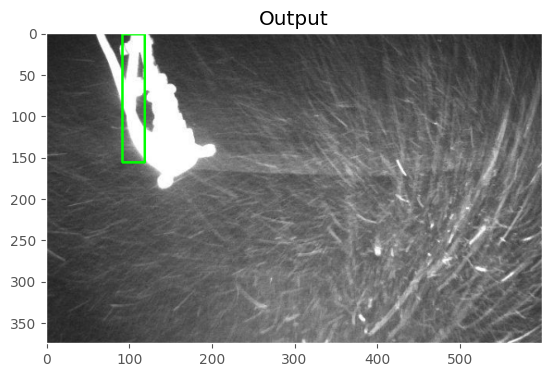

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


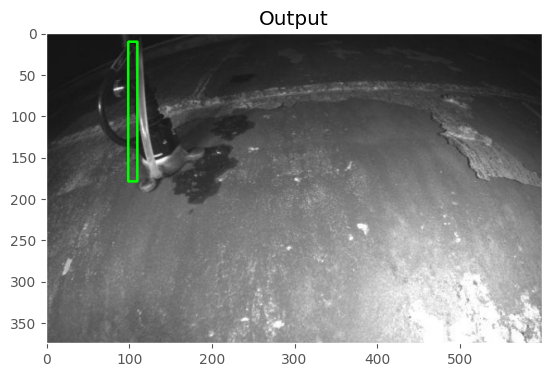

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


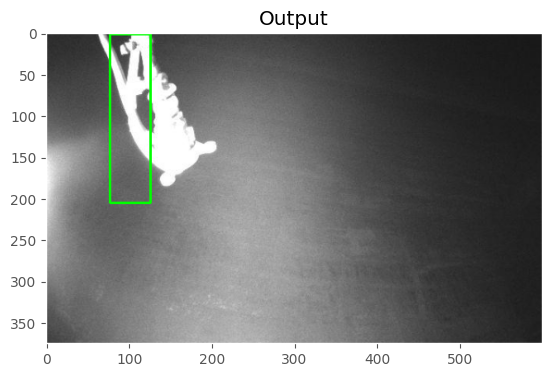

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


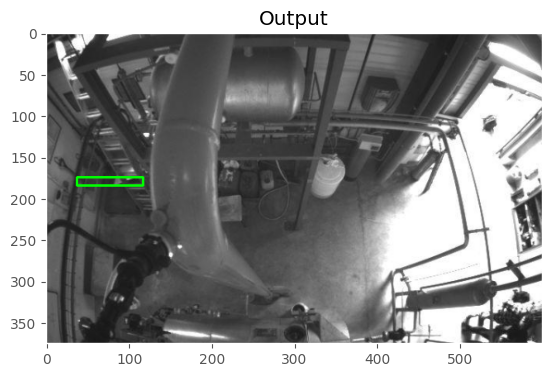

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


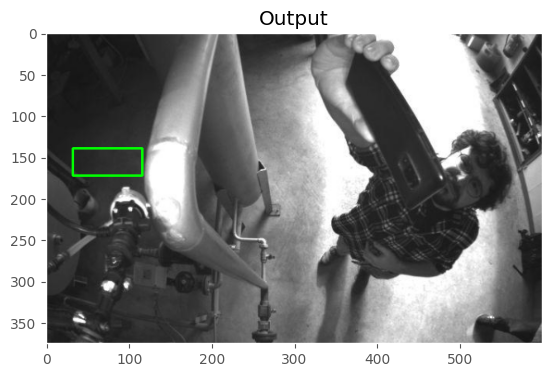

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


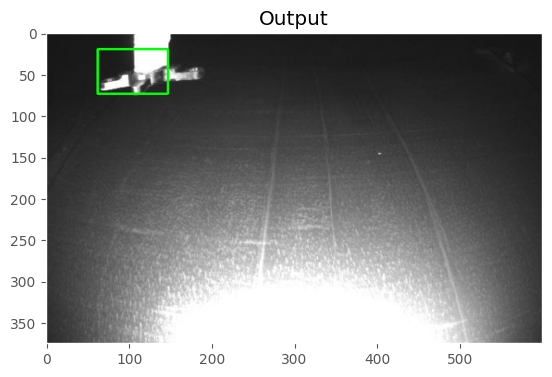

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


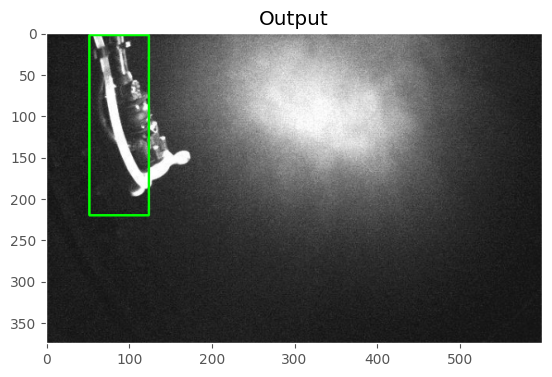

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


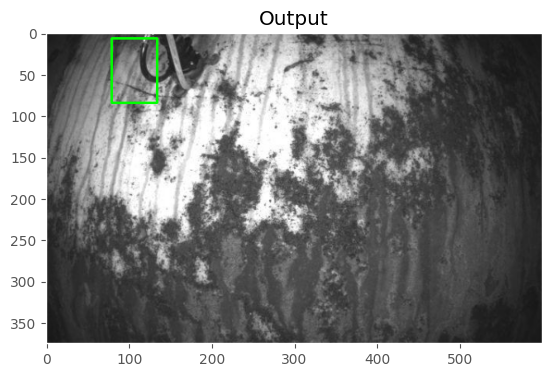

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


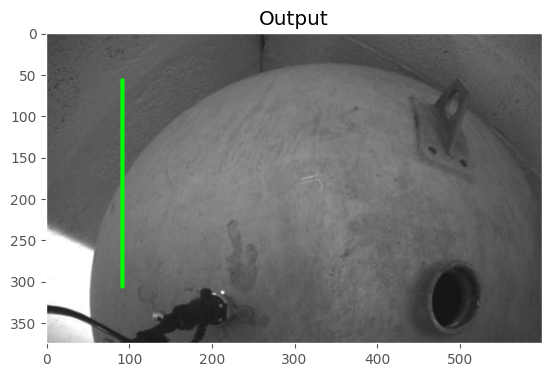

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


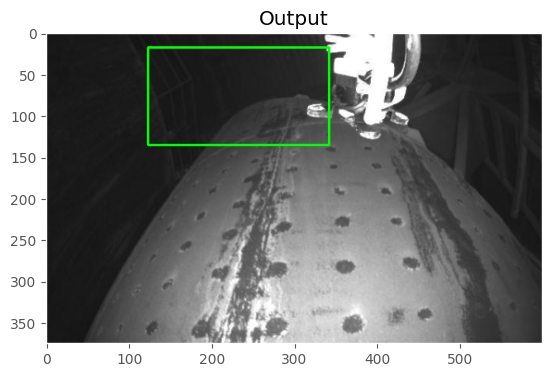

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


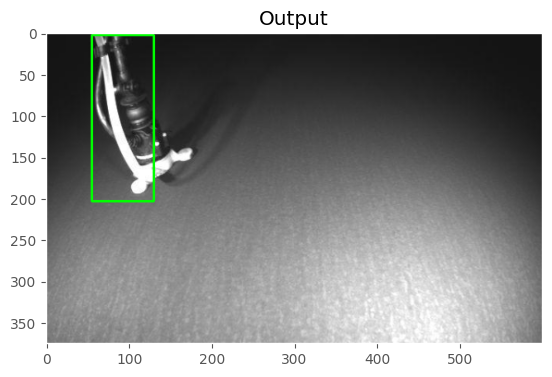

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


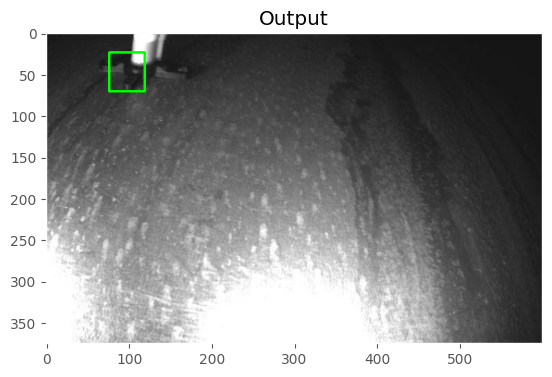

In [19]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
# model = load_model(config.MODEL_PATH)

# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)

	# make bounding box predictions on the input image
	preds = model.predict(image)[0]
	(startX, startY, endX, endY) = preds

	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]

	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)

	# draw the predicted bounding box on the image
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)

	# show the output image
	plt_imshow("Output", image)